# Objective

- We will consider the same case study we discussed in class, where we are interested in running an A/B test for determining the best of two possible ads designs, ads A and B, running on the same marketing channel based on their Click Through Rate (CTR), wich is simply the number of clicks the ad gets out of the total number of impressions (views)



- Rather than using the daily CTR data as we did in class, we will use the ad-click events data collected from the website directly



- Our objetive is the same: Is Ad A better than B or vice versa ? If yes, by how much ?

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm

## 1. Data

In [2]:
# We will synthesize the collected click events data here ourselves as follows:

# we can drop the assumption that we have equal number of impressions during the 30 days the test was running

CTR_A_true = 3.0 
CTR_B_true = 3.5 # Let's make CTR_B 15% better, similar to what we did in class

N_impressions_A = 5000
N_impressions_B = 7500

# we are using a Bernoulli RV here with prob('user clicks the Ad') = prob('1') = CTR/100
p_A_true = CTR_A_true/100
p_B_true = CTR_B_true/100

data_user_A = stats.bernoulli.rvs(p_A_true, size=N_impressions_A)
data_user_B = stats.bernoulli.rvs(p_B_true, size=N_impressions_B)

print("observed CTR_A = ", np.sum(data_user_A)*100/N_impressions_A)
print("observed CTR_B = ", np.sum(data_user_B)*100/N_impressions_B)

observed CTR_A =  3.12
observed CTR_B =  3.52


## 2. Analysis (Fill in the Blanks)

### Step 1: Choose a likelihood distribution for the observed data → how can the data be generated ?

In [3]:
# since we know CTR or p is between 0 and 1 and we can assume we have no prior idea of the value, 

# we can use a uniform prior for both p_A and p_B

with pm.Model() as ab_test:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)

In [4]:
# Define the deterministic delta function, which is the difference between both CTRs 
    
with ab_test:    
    delta = pm.Deterministic("delta", p_B - p_A)


In [5]:
# what liklihood function does our data follow ? 
# since we are modeling binary data, the Bernoulli RV is the suitable choice

with ab_test:       
    obs_A = pm.Bernoulli("obs_A", p_A, observed=data_user_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=data_user_B)

In [6]:
# sample the posterior distributions

with ab_test:
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, return_inferencedata=False)
    usable_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
# extract samples of posterior distributions

p_A_samples = usable_trace["p_A"]
p_B_samples = usable_trace["p_B"]
delta_samples = usable_trace["delta"]

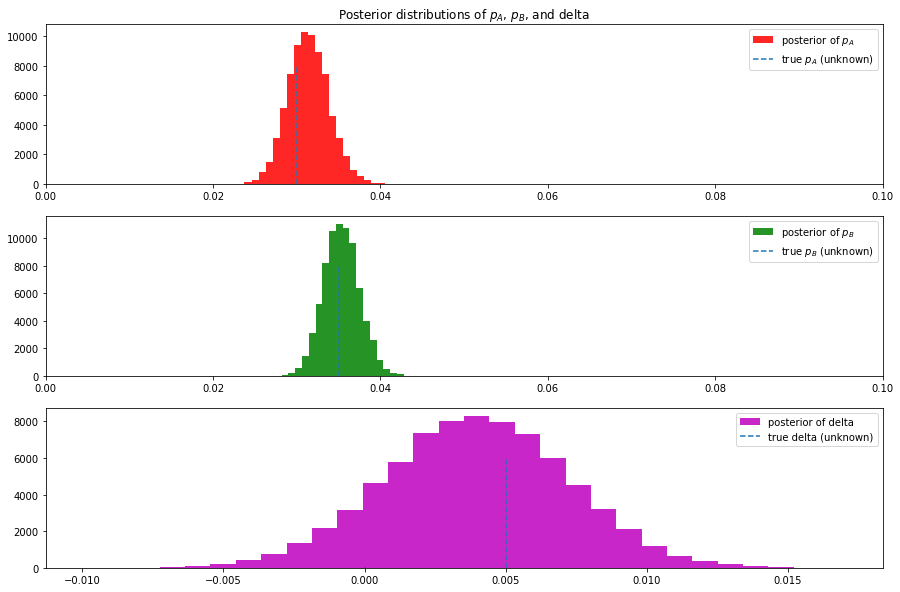

In [8]:
# plot the histograms of the posteriors

figsize(15, 10)
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="r")
plt.vlines(p_A_true, 0, 8000, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85, label="posterior of $p_B$", color="g")
plt.vlines(p_B_true, 0, 8000, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of delta", color="m")
plt.vlines(p_B_true - p_A_true, 0, 6000, linestyle="--", label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [9]:
# count the number of posterior distribution samples of delta which are less than 0
# this is equivalent to the area under the curve before 0
# this in turn represents the probability that site A is worse than site B

print("Probability Ad B is WORSE than Ad A = {}".format(np.mean(delta_samples < 0)))
    

print("Probability Ad B is BETTER than Ad A = {}".format(np.mean(delta_samples > 0)))
    

print("Estimated Improvement of CTR of Ad B over Ad A = {}".format(np.mean(delta_samples)*100))

Probability Ad B is WORSE than Ad A = 0.11257894736842106
Probability Ad B is BETTER than Ad A = 0.887421052631579
Estimated Improvement of CTR of Ad B over Ad A = 0.39344897002014406
